In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import cv2
import os
import scipy.io
import matplotlib.pyplot as plt
import scipy.optimize as opt
import plotly.graph_objs as graph
import matplotlib.animation as animation
from IPython.display import HTML

#Read the mat files for matched points
matches = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/MatchedPoints.mat')['matchedPoints']
#Read the mat files for Camera Intrinsic matrix
intrinsic_matrix = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/IntrinsicsMCV.mat')['IntrinsicMatrix']

In [7]:
#Focal length of the camera is located at positions 0,0 and 1,1 in 3x3 camera matrix
focx, focy = intrinsic_matrix[0,0], intrinsic_matrix[1,1]
#Offset is located at positions 0,2 and 1,2 in 3x3 camera matrix
offx, offy = intrinsic_matrix[0,2], intrinsic_matrix[1,2]

In [8]:
def convulated_coords(matches):
  #Normalise the coordinates as asked in assignment5 section 2.1 point (a)
  norm_coords = np.zeros(matches.shape)
  for i, matchset in enumerate(matches):
    norm_coords[i, 0], norm_coords[i, 1] = (matchset[0]-offx)/focx, (matchset[1]-offy)/focy
  return norm_coords

norm_Coords = convulated_coords(matches)
def create_rotation_matrix(angles, views):
    # Create rotation matrix as per the number of views/frames
    Rotation_mat = np.ones((views,3,3))
    rx, ry, rz = angles.T
    # Storing the rotation values in Roation matrix for all views
    # This matrix is the same as matrix shown in section 2.1 assignment 5 pdf
    Rotation_mat[:,0,1], Rotation_mat[:,0,2] = -rz, ry
    Rotation_mat[:,1,0], Rotation_mat[:,1,2] = rz, -rx
    Rotation_mat[:,2,0], Rotation_mat[:,2,1] = -ry, rx
    return Rotation_mat

def reprojected_camera_cord(world_cord, theta, T, num_cams, num_features):
    # Derive rotation matrix
    Rot_mat = create_rotation_matrix(theta, num_cams)
    # Calculate the homogeneous projected camera coordinates
    res = np.matmul(Rot_mat , world_cord.T) + T.reshape(num_cams,3,1)
    # Derive heterogeneous coordinates
    res = res[:,:2,:]/res[:,2,:].reshape(num_cams,1,num_features) 
    return res

def func_wrapper(x,**kwargs) :
    num_cams = kwargs['num_cams']
    num_params = kwargs['num_matches']
        
    # Getting the depth values from the feature vector... 
    Ws = x[:num_params]
    # Getting the angle vectors from the feature vector and reshaping to required shape... 
    angles = x[num_params:num_params+3*num_cams].reshape(num_cams,3)
    # Getting the translation vectors from the feature vector and reshaping to required shape... 
    Ts = x[num_params+3*num_cams:].reshape(num_cams,3)
    
    # Getting the reference coordinates from normalied camera coords... 
    Ps = norm_Coords[:,:,0]
    # np.vstack(x,y) stacks x,y vertically. Check documentation for further clarifications...
    Ps = np.vstack(((Ps)[:,0]/Ws, (Ps[:,1]/Ws, np.ones(num_params)/Ws))).T
    
    # Returning the residuals after computing them as in the pdf...
    return ((norm_Coords[:,:,:num_cams] - reprojected_camera_cord(Ps, angles, Ts, num_cams, num_params).T)**2).ravel()

In [9]:
def Bundle_Adjust(matches, n_Views=None):
    if n_Views is None:
        n_Views = matches.shape[2]
    
    # Storing the number of feature matches for ease...
    num_matches = matches.shape[0]   
    # The initial value of the feature vector as given in the pdf.
    x0 = np.hstack((np.ones(num_matches),np.zeros(n_Views*6)))
    
    # Getting the optimal feature vector using scipy.optimize.least_squares()...
    X_opt = opt.least_squares(func_wrapper , x0 = x0 ,verbose = 2, kwargs={'num_cams':n_Views,'num_matches':num_matches})
    X_opt = X_opt['x']
    
    # Getting the optimal depth, rotation and translation vectors from the optimal feature vector...
    Ws = X_opt[:num_matches]
    angles = X_opt[num_matches:num_matches+3*n_Views].reshape(n_Views,3)
    Ts = X_opt[num_matches+3*n_Views:].reshape(n_Views,3)
    
    # Returning the required output...
    return Ws, angles, Ts

In [10]:
def plot_3D(W):
    X,Y,Z = np.append(norm_Coords[:,:,0].T,np.ones((1,norm_Coords.shape[0])),axis=0)/W
    plt_3D = graph.Figure(data=[graph.Scatter3d(x=X, y=Y, z=Z, mode= "markers", marker={"size":2})])
    plt_3D.show()

In [11]:
depth_5, angles_5, T_5 = Bundle_Adjust(norm_Coords, n_Views=5)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7854e-05                                    2.79e-03    
       1              2         7.0273e-06      1.08e-05       2.84e+01       2.82e-03    
       2              3         2.1324e-07      6.81e-06       2.84e+01       1.03e-04    
       3              4         1.8657e-08      1.95e-07       5.68e+01       1.66e-05    
       4              6         3.0005e-09      1.57e-08       2.84e+01       5.12e-06    
       5              8         2.4709e-09      5.30e-10       1.42e+01       2.96e-06    
       6              9         4.3736e-10      2.03e-09       3.55e+00       7.62e-07    
       7             10         1.5297e-10      2.84e-10       7.10e+00       2.43e-07    
       8             11         1.0941e-10      4.36e-11       7.10e+00       1.70e-07    
       9             12         7.9806e-11      2.96e-11       7.10e+00       1.31e-07    

In [12]:
plot_3D(depth_5)

In [13]:
depth_15, angles_15, T_15 = Bundle_Adjust(norm_Coords, n_Views=15)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2726e-04                                    1.95e-02    
       1              2         2.9783e-04      1.29e-04       2.84e+01       2.91e-02    
       2              3         3.4063e-05      2.64e-04       2.84e+01       3.29e-03    
       3              4         2.4182e-06      3.16e-05       5.68e+01       5.20e-04    
       4              6         4.4004e-07      1.98e-06       2.84e+01       1.69e-04    
       5              8         2.0284e-07      2.37e-07       1.42e+01       5.20e-05    
       6             10         2.5280e-08      1.78e-07       3.55e+00       1.09e-05    
       7             12         2.8335e-09      2.24e-08       1.78e+00       2.01e-06    
       8             13         5.0607e-10      2.33e-09       3.55e+00       2.49e-07    
       9             14         3.3528e-10      1.71e-10       7.10e+00       2.45e-07    

In [14]:
plot_3D(depth_15)

In [15]:
depth_25, angles_25, T_25 = Bundle_Adjust(norm_Coords)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1260e-03                                    3.58e-02    
       1              2         6.4174e-04      4.84e-04       2.84e+01       1.91e-02    
       2              3         1.3035e-05      6.29e-04       2.84e+01       1.34e-03    
       3              6         1.1491e-06      1.19e-05       3.55e+00       2.13e-04    
       4              7         2.9342e-07      8.56e-07       7.10e+00       7.26e-05    
       5              8         2.5705e-07      3.64e-08       1.42e+01       1.16e-04    
       6              9         3.5008e-08      2.22e-07       3.55e+00       2.50e-05    
       7             10         4.6727e-09      3.03e-08       7.10e+00       5.30e-06    
       8             12         1.2627e-09      3.41e-09       3.55e+00       1.03e-06    
       9             14         8.0725e-10      4.55e-10       1.78e+00       1.87e-07    

In [16]:
plot_3D(depth_25)

# Plane Sweep


In [35]:
sequence = []
for img in os.listdir('/content/drive/MyDrive/Colab Notebooks/sequence/'):
    sequence.append(cv2.imread('/content/drive/MyDrive/Colab Notebooks/sequence/'+img))
    sequence[-1] = sequence[-1][:,:,::-1]

seq_len = len(sequence)
num_points = matches.shape[0]

In [36]:
def view_animated_sequence(sequence):
    # Number of fraames
    n_Frames = sequence.shape[0]
    
    # Acquire the first frame
    fig, ax = plt.subplots()
    frame = ax.imshow(sequence[0,:,:,:])
    plt.xticks([]), plt.yticks([])
    
    # Acquire the animated frames
    def next_Frame(i):
        img = sequence[i,:,:,:]
        frame.set_data(img)
        return frame
    
    # So that no value is returned...
    plt.close()
    # Generating the animation...
    anim = animation.FuncAnimation(fig, next_Frame, frames=n_Frames, repeat=False)  
    # Displaing the animation...
    display(HTML(anim.to_html5_video()))

view_animated_sequence(np.array(sequence))

Minimum depth : 0.32823345440728907 
Maximum depth: 1.061167510617139

Candidate Depths : [0.32823345 0.40967057 0.49110769 0.57254481 0.65398192 0.73541904
 0.81685616 0.89829328 0.97973039 1.06116751]


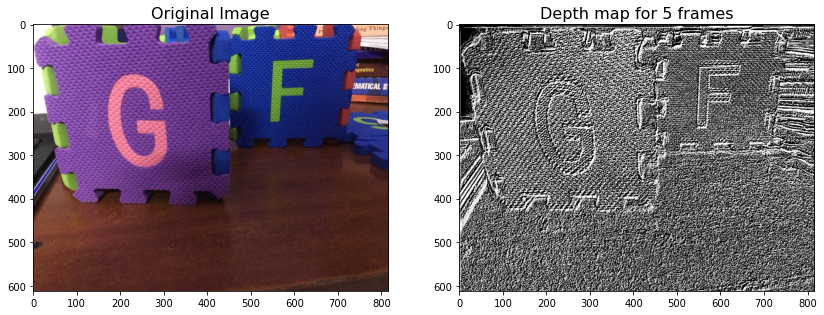

In [40]:
d_min, d_max = 1/depth_25.max(), 1/depth_25.min()
print("Minimum depth :",d_min, "\nMaximum depth:",d_max)

# The number of Depth Candidates
Nd = 10
# The depth candidate array
D = np.linspace(d_min, d_max, Nd)
print("\nCandidate Depths :",D)

H, W = sequence[0].shape[0], sequence[0].shape[1]

Rs = create_rotation_matrix(angles_25, seq_len)
# Declaring "n" as in the pdf of assignment5
n = np.array([0,0,-1]).T
# Getting the inverse of the intrinsics matrix
intrinsic_matrix_inv = np.linalg.inv(intrinsic_matrix)

sequence_gray = [cv2.cvtColor(sequence[i], cv2.COLOR_BGR2GRAY) for i in range(seq_len)]

sequence_gray = [cv2.cvtColor(sequence[i], cv2.COLOR_BGR2GRAY) for i in range(seq_len)]


def generate_depth_map(Nframes=None):
    # Setting the number of frames to 25 if no value is specified
    if Nframes is None:
        Nframes = seq_len

    # Creating a 4D array(tensor) to store the homographies
    warped_imgs = np.zeros((H,W, Nd, Nframes))

    # Iterating through the Nd depths and the number of frames considered
    for i in range(Nd):
        for j in range(Nframes):
            H_di = np.matmul(np.matmul(intrinsic_matrix, (Rs[j] - np.matmul(n, T_25[j])/D[i])),intrinsic_matrix_inv)

            warp = cv2.warpPerspective(sequence_gray[j], np.linalg.inv(H_di), dsize=(W,H))
            warped_imgs[:, :, i, j] = warp

    # Find the variances across the frame axis
    vars = np.var(warped_imgs, axis=3)
    # Find argmin of variance for each pixel and create the depth map
    depth_map = D[np.argmin(vars, axis=2)]
    return depth_map

def display_depth_map(depth_map, N):
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.imshow(sequence[0], cmap='gray')
    plt.title("Original Image", fontsize = 16, color='black')
    plt.subplot(1,2,2)
    plt.imshow(depth_map, cmap='gray')
    plt.title(f"Depth map for {N} frames", fontsize = 16, color='black')
    plt.show()


depth_map = generate_depth_map(5)
display_depth_map(depth_map, N=5)

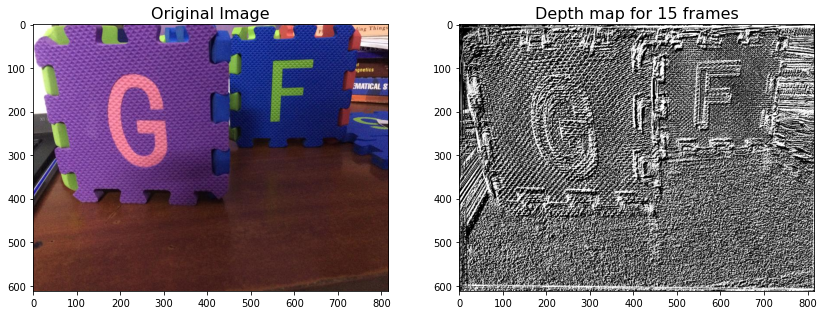

In [41]:
depth_map = generate_depth_map(15)
display_depth_map(depth_map, N=15)

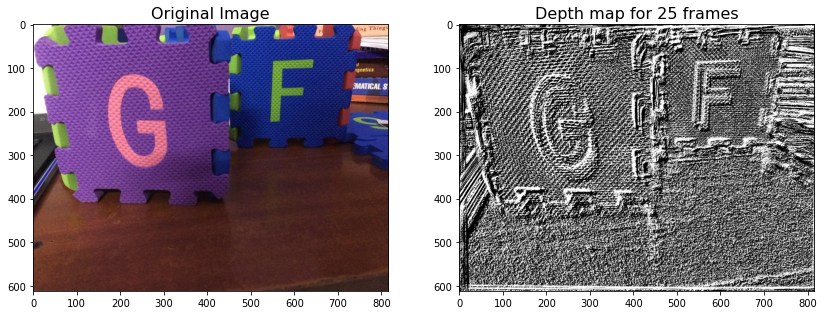

In [42]:
depth_map = generate_depth_map(25)
display_depth_map(depth_map, N=25)